    ** The notebook consist of my work on the assignment shared by "Hacker-Earth".
    ** I perceive the Problem Statement as multi-class classification problem with NLP driven feature extraction.
    ** The Outline next course of Action :
            a. Problem Statement
            b. Load Input Data
            c. Exploratory Data Analysis
            d. Pre-Processing
            e. Data Sampling & Splitting (Train-Validation) : I used LGBM CV
            f. Feature Engineering
            g. Feature Selection
            h. Model Training
            i. Model Hyper-Space Tuning : Not Enough power in my Laptop so, I had eyeball the hyper-space.
            j. Model Evaluation            

# Problem Statement 

![alt text](problem_statement_.JPG "Title")

![alt text](data_description.JPG "Title")

# Load libraries 

In [1]:
import pycm
import pandas as pd
import numpy as np
import warnings
import os
import re
import math
import time
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from multiprocessing import Pool
import swifter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

In [2]:
import nltk
import spacy
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

In [3]:
from lightgbm import LGBMClassifier

In [4]:
import scipy

# Tools & Utilities 

In [5]:
target_mapping = {
    'affection': 1,
    'achievement': 2,
    'bonding': 3,
    'enjoy_the_moment': 4,
    'leisure': 5,
    'nature': 6,
    'exercise': 7
}

## Pre-Processing 

In [4]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [5]:
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join(
        [word for word in str(text).split() if word not in STOPWORDS])

In [6]:
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "J": wordnet.ADJ,
        "R": wordnet.ADV
    }
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([
        lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN))
        for word, pos in pos_tagged_text
    ])

In [7]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [8]:
def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [9]:
def correct_spellings(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [10]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [9]:
def pre_process(input_df):
    input_df['cleaned_hm'] = input_df.cleaned_hm.astype(str)
    input_df["pre_processed_clean_hm"] = input_df["cleaned_hm"].str.lower()
    input_df["pre_processed_clean_hm"] = input_df[
        "pre_processed_clean_hm"].swifter.apply(
            lambda text: remove_punctuation(text))
    input_df["pre_processed_clean_hm"] = input_df[
        "pre_processed_clean_hm"].swifter.apply(
            lambda text: remove_stopwords(text))
    input_df["pre_processed_clean_hm"] = input_df[
        "pre_processed_clean_hm"].swifter.apply(
            lambda text: lemmatize_words(text))
    input_df["pre_processed_clean_hm"] = input_df[
        "pre_processed_clean_hm"].swifter.apply(
            lambda text: chat_words_conversion(text))
    return input_df

## Feature Engineering 

In [6]:
def entropy(s):
    l = float(len(s))
    return (-sum(map(lambda a: (a / l) * math.log2(a / l),
                     Counter(s).values())))

In [7]:
pos_family = {
    'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
    'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
    'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    'adj': ['JJ', 'JJR', 'JJS'],
    'adv': ['RB', 'RBR', 'RBS', 'WRB']
}


def check_pos_tag(x, flag):
    cnt = 0
    try:
        k = pd.Series([
            list(x)[1] for x in nltk.pos_tag(nltk.word_tokenize(str(x)))
        ]).value_counts()
        for i in pos_family[flag]:
            if i in k.index.tolist():
                cnt = cnt + k[i]
    except:
        pass
    return cnt

In [8]:
def extract_density_based_features(data, column='pre_processed_clean_hm'):
    feature_df = pd.DataFrame()

    feature_df['char_count'] = data[column].apply(len)
    feature_df['content_word_count'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: len(str(x).split(" ")))
    feature_df['noun_count'] = data[
        'pre_processed_clean_hm'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'noun'))
    feature_df['verb_count'] = data[
        'pre_processed_clean_hm'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'verb'))
    feature_df['adj_count'] = data[
        'pre_processed_clean_hm'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'adj'))
    feature_df['adv_count'] = data[
        'pre_processed_clean_hm'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'adv'))
    feature_df['pron_count'] = data[
        'pre_processed_clean_hm'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'pron'))
    feature_df['word_density'] = feature_df['char_count'] / (
        feature_df['content_word_count'] + 1)
    feature_df['avg_word_length'] = feature_df['content_word_count'] / \
        (feature_df['char_count']+1)
    feature_df['noun_density'] = feature_df['noun_count'] / (
        feature_df['content_word_count'] + 1)
    feature_df['verb_density'] = feature_df['verb_count'] / (
        feature_df['content_word_count'] + 1)
    feature_df['adj_density'] = feature_df['adj_count'] / (
        feature_df['content_word_count'] + 1)
    feature_df['adv_density'] = feature_df['adv_count'] / (
        feature_df['content_word_count'] + 1)
    feature_df['pron_density'] = feature_df['pron_count'] / (
        feature_df['content_word_count'] + 1)
    feature_df['avg_pos_density'] = (feature_df[[
        'noun_density', 'verb_density', 'adj_density', 'adv_density',
        'pron_density'
    ]].sum(axis=1) / 5)
    return feature_df

In [9]:
def add_static_column_features(data, column='cleaned_hm'):
    feature_df = pd.DataFrame()

    feature_df['no_of_dots'] = data[column].swifter.set_npartitions(8).apply(
        lambda x: str(x).count('.')).copy()
    feature_df['no_of_hyphen'] = data[column].swifter.set_npartitions(8).apply(
        lambda x: str(x).count('-')).copy()
    feature_df['no_of_underscore'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: str(x).count('_')).copy()
    feature_df['no_of_equal'] = data[column].swifter.set_npartitions(8).apply(
        lambda x: str(x).count('=')).copy()
    feature_df['no_of_forward_slash'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: str(x).count('/')).copy()
    feature_df['no_of_question_marks'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: str(x).count('?')).copy()
    feature_df['no_of_semicolon'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: str(x).count(';')).copy()
    feature_df['no_of_open_parenthesis'] = data[
        column].swifter.set_npartitions(8).apply(
            lambda x: str(x).count('(')).copy()
    feature_df['no_of_mod'] = data[column].swifter.set_npartitions(8).apply(
        lambda x: str(x).count('%')).copy()
    feature_df['no_of_ampersand'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: str(x).count('&')).copy()
    feature_df['no_of_@'] = data[column].swifter.set_npartitions(8).apply(
        lambda x: str(x).count('@')).copy()
    feature_df['no_of_double_slash'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: str(x).count('//')).copy()
    feature_df['no_of_digits'] = data[column].swifter.set_npartitions(8).apply(
        lambda x: sum(c.isdigit() for c in x)).copy()
    feature_df['column_entropy'] = data[column].swifter.set_npartitions(
        8).apply(lambda x: entropy(x)).copy()
    return feature_df

## Model Evaluate 

In [10]:
import sklearn
from sklearn import metrics

In [11]:
def evaluate_model(Y_actual, Y_predicted):

    confusion_matrix_class = pycm.ConfusionMatrix(actual_vector=Y_actual,
                                                  predict_vector=Y_predicted)

    TPR = []
    PPV = []
    FPR = []
    FNR = []
    ACC = []
    F1 = []

    FP = confusion_matrix_class.FP.values()
    FN = confusion_matrix_class.FN.values()
    TP = confusion_matrix_class.TP.values()
    TN = confusion_matrix_class.TN.values()

    FPR_ = (sum(FP) / (sum(FP) + sum(TN)))
    FNR_ = (sum(FN) / (sum(FN) + sum(TP)))

    ACC_ = ((sum(TP) + sum(TN)) / (sum(FN) + sum(TP) + sum(TN) + sum(FP)))

    TPR.append(
        np.where((confusion_matrix_class.overall_stat['TPR Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['TPR Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['TPR Micro']))
    PPV.append(
        np.where((confusion_matrix_class.overall_stat['PPV Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['PPV Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['PPV Micro']))

    FPR.append(round(FPR_, 4))
    FNR.append(round(FNR_, 4))
    ACC.append(round(ACC_, 4))

    F1.append(
        np.where((confusion_matrix_class.overall_stat['F1 Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['F1 Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['F1 Micro']))

    for i in confusion_matrix_class.classes:

        TPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['TPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['TPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['TPR'][i])), 4))

        PPV.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['PPV'][i] == 'None')
                        | (confusion_matrix_class.class_stat['PPV'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['PPV'][i])), 4))

        FPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FPR'][i])), 4))
        FNR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FNR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FNR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FNR'][i])), 4))

        ACC.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['ACC'][i] == 'None')
                        | (confusion_matrix_class.class_stat['ACC'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['ACC'][i])), 4))
        F1.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['F1'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['F1'][i] == np.nan),
                        -0.99, confusion_matrix_class.class_stat['F1'][i])),
                4))

    eval_df = pd.DataFrame()
    index = ['overall']
    index.extend(confusion_matrix_class.classes)
    eval_df['Recall'] = TPR
    eval_df['Precision'] = PPV
    eval_df['False_Positive_Rate'] = FPR
    eval_df['False_Negative_Rate'] = FNR
    eval_df['Accuracy'] = ACC
    eval_df['F1_Score'] = F1
    eval_df.index = index

    return (eval_df[['Recall', 'Precision', 'F1_Score'
                     ]]) * 100

In [12]:
def get_key(val):
    for key, value in target_mapping.items():
        if val == value:
            return key

    return "key doesn't exist"

# Load Data

In [17]:
train = pd.read_csv("C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_train.csv")
print(train.shape)
train.head()

(60321, 5)


,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I felt sympathy and connection with.,1,affection
1,27674,24h,I was happy when my son got 90% marks in his examination,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,2,bonding
4,27677,24h,I went with grandchildren to butterfly display at Crohn Conservatory\r\r\n,1,affection


In [18]:
test = pd.read_csv("C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_test.csv")
print(test.shape)
test.head()

(40213, 4)


,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,3m,I spent the weekend in Chicago with my friends.,1
1,88306,3m,We moved back into our house after a remodel. We had lived in a hotel for 9 months due to our home being severely damaged in a tornado.,2
2,88307,3m,My fiance proposed to me in front of my family in the beginning of March.,1
3,88308,3m,I ate lobster at a fancy restaurant with some friends.,1
4,88309,3m,"I went out to a nice restaurant on a date with my wife. It was a very popular restaurant and we could not get a reservation. But I have a friend who owns a famous hamburger place next door to this restaurant. He was able to get us a table! We had a great table, great service, great food, and they even comped most of our dinner, so we paid almost nothing!",5


### Data-Type

In [16]:
train.dtypes

hmid                   int64
reflection_period     object
cleaned_hm            object
num_sentence           int64
predicted_category    object
dtype: object

# Exploratory Data Analysis 

In [7]:
train.predicted_category.value_counts()

affection           20880
achievement         20274
bonding              6561
enjoy_the_moment     6508
leisure              4242
nature               1127
exercise              729
Name: predicted_category, dtype: int64

In [8]:
train_raw.reflection_period.value_counts()

24h    30455
3m     29866
Name: reflection_period, dtype: int64

In [9]:
pd.crosstab(train_raw.reflection_period,train_raw.predicted_category)

predicted_category,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature
reflection_period,,,,,,,
24h,9272,10157,3276,3982,482,2598,688
3m,11002,10723,3285,2526,247,1644,439


<AxesSubplot:>

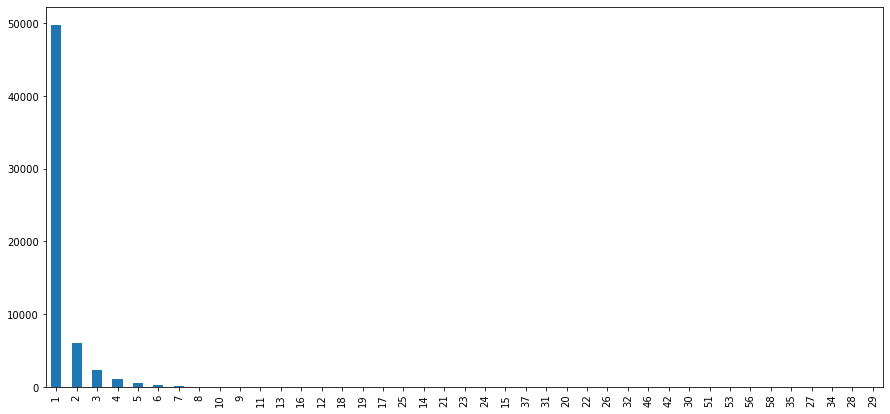

In [13]:
plt.figure(figsize=(15,7))
train_raw.num_sentence.value_counts().plot(kind='bar')

In [51]:
train_pre_processed.isnull().sum()

hmid                      0
reflection_period         0
cleaned_hm                0
num_sentence              0
predicted_category        0
pre_processed_clean_hm    0
target                    0
dtype: int64

In [52]:
test_pre_processed.isnull().sum()

hmid                      0
reflection_period         0
cleaned_hm                0
num_sentence              0
pre_processed_clean_hm    0
dtype: int64

In [29]:
train.cleaned_hm.apply(len).value_counts()

58      726
50      703
54      692
57      687
60      682
55      676
64      675
49      673
48      672
56      670
43      665
53      661
47      659
39      654
38      652
52      651
40      645
45      645
59      641
42      639
44      637
51      628
46      627
63      621
62      606
67      600
69      598
65      593
61      593
41      593
68      588
34      587
71      583
36      575
35      574
74      568
76      567
66      566
37      564
30      552
72      551
33      538
70      534
73      524
77      516
32      511
75      507
79      495
81      491
29      488
78      488
82      487
31      480
80      479
84      477
28      452
83      452
85      443
26      428
86      419
87      418
27      409
90      406
89      387
95      372
88      364
25      361
94      354
93      351
91      346
23      342
92      341
99      329
102     326
96      322
24      313
104     310
97      307
98      300
22      298
100     296
18      293
101     289
103 

# Data Pre-Processing

    ** Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.
    As a result, this one is generally slower than stemming process. However, based on my experience I have observed lemmatization work better than stemming hence, I would opt this.
    ** Also, in this context good || better || best can be associated to different classes in the targets hence, lemmatization help in keeping all these variants

    ** Emoji Related Pre-Processing is Not Required for this dataset

    ** There might be the case where while writing the moment folks might have used chat related short forms so to handle these we will do proper pre-processing

    ** One another important text preprocessing step is spelling correction. Typos are common in text data and we might want to correct those spelling mistakes before we do our analysis.

In [19]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)
del line,cw,cw_expanded

In [20]:
train_pre_processed = pre_process(train)

In [21]:
test_pre_processed = pre_process(test)

In [22]:
train_pre_processed[
    'target'] = train_pre_processed.predicted_category.swifter.apply(
        lambda x: target_mapping[x]).copy()

In [25]:
train_pre_processed.to_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_train_pre_processed.pkl"
)
test_pre_processed.to_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_test_pre_processed.pkl"
)

# Feature Extraction

In [13]:
train_pre_processed=pd.read_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_train_pre_processed.pkl"
)
test_pre_processed=pd.read_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_test_pre_processed.pkl"
)

In [14]:
train_pre_processed.sample(5)

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category,pre_processed_clean_hm,target
27497,55322,24h,"well happy in my life in happy describel in m life Would your current boss describe you as the type of person who goes that extra mile Give us an example of a situation where you faced conflict or difficult ... Tell me about a special contribution you have made to your employer. ..... stress of being yelled at and gave him what he wanted, so I'm happy.",2,enjoy_the_moment,well happy life happy describel life would current boss describe type person go extra mile give You example situation face conflict difficult tell special contribution make employer stress yell give want im happy,4
44066,71975,3m,I got a job I wanted.,1,achievement,get job want,2
19452,47234,24h,Today I received a salary,1,achievement,today receive salary,2
14569,42333,24h,"It was Sunday, and I got to relax at home.",1,enjoy_the_moment,sunday get relax home,4
36447,64322,3m,"Today it was raining, warm, and sunny -- all at the same time.",1,nature,today rain warm sunny time,6


In [316]:
train_features = pd.DataFrame()
test_features = pd.DataFrame()

## POS Density Based Features 

In [16]:
train_features = extract_density_based_features(train_pre_processed)
test_features = extract_density_based_features(test_pre_processed)

In [17]:
display(train_features.sample(5))
display(test_features.sample(5))

,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density
29543,55,7,7,0,0,0,0,6.875000,0.125000,0.875000,0.000000,0.000000,0.0,0.0,0.175000
23820,25,4,3,0,1,0,0,5.000000,0.153846,0.600000,0.000000,0.200000,0.0,0.0,0.160000
12136,75,13,6,1,6,0,0,5.357143,0.171053,0.428571,0.071429,0.428571,0.0,0.0,0.185714
23132,20,3,3,0,0,0,0,5.000000,0.142857,0.750000,0.000000,0.000000,0.0,0.0,0.150000
5822,45,9,3,2,3,0,0,4.500000,0.195652,0.300000,0.200000,0.300000,0.0,0.0,0.160000


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density
1911,42,8,5,2,1,0,0,4.666667,0.186047,0.555556,0.222222,0.111111,0.000000,0.000000,0.177778
15038,88,16,6,5,2,1,0,5.176471,0.179775,0.352941,0.294118,0.117647,0.058824,0.000000,0.164706
33307,24,4,2,0,1,1,0,4.800000,0.160000,0.400000,0.000000,0.200000,0.200000,0.000000,0.160000
39801,137,20,10,2,6,0,2,6.523810,0.144928,0.476190,0.095238,0.285714,0.000000,0.095238,0.190476
18233,80,14,6,0,5,1,0,5.333333,0.172840,0.400000,0.000000,0.333333,0.066667,0.000000,0.160000


## Static Features 

In [18]:
train_features = pd.concat(
    [train_features,
     add_static_column_features(train_pre_processed)],
    axis=1,
    copy=True)
test_features = pd.concat(
    [test_features,
     add_static_column_features(test_pre_processed)],
    axis=1,
    copy=True)

In [19]:
display(train_features.sample(5))
display(test_features.sample(5))

,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy
212,27,4,2,1,1,0,0,5.400000,0.142857,0.400000,0.200000,0.200000,0.000000,0.0,0.160000,0,0,0,0,0,0,0,0,0,0,0,0,0,3.915746
50549,47,9,6,1,2,0,0,4.700000,0.187500,0.600000,0.100000,0.200000,0.000000,0.0,0.180000,1,0,0,0,0,0,0,0,0,0,0,0,0,4.157409
11233,28,4,2,0,2,0,0,5.600000,0.137931,0.400000,0.000000,0.400000,0.000000,0.0,0.160000,0,0,0,0,0,0,0,0,0,0,0,0,0,3.900150
24087,37,6,4,0,2,0,0,5.285714,0.157895,0.571429,0.000000,0.285714,0.000000,0.0,0.171429,1,0,0,0,0,0,0,0,0,0,0,0,0,3.926272
21607,83,11,6,1,3,1,0,6.916667,0.130952,0.500000,0.083333,0.250000,0.083333,0.0,0.183333,1,1,0,0,0,0,0,0,0,0,0,0,0,4.117562


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy
33966,45,10,3,4,2,1,0,4.090909,0.217391,0.272727,0.363636,0.181818,0.090909,0.0,0.181818,1,0,0,0,0,0,0,0,0,0,0,0,0,3.793578
22100,20,4,2,1,0,0,0,4.000000,0.190476,0.400000,0.200000,0.000000,0.000000,0.0,0.120000,1,0,0,0,0,0,0,0,0,0,0,0,1,3.905216
35780,58,10,5,2,1,2,0,5.272727,0.169492,0.454545,0.181818,0.090909,0.181818,0.0,0.181818,1,0,0,0,0,0,0,0,0,0,0,0,0,4.089446
11570,28,5,2,1,2,0,0,4.666667,0.172414,0.333333,0.166667,0.333333,0.000000,0.0,0.166667,1,0,0,0,0,0,0,0,0,0,0,0,0,4.042524
24805,67,11,6,2,3,0,0,5.583333,0.161765,0.500000,0.166667,0.250000,0.000000,0.0,0.183333,2,0,0,0,0,0,0,0,0,0,0,0,0,4.154351


## TF-IDF

In [ ]:
[
    'char_count', 'content_word_count', 'noun_count', 'verb_count',
    'adj_count', 'adv_count', 'pron_count', 'word_density', 'avg_word_length',
    'noun_density', 'verb_density', 'adj_density', 'adv_density',
    'pron_density', 'avg_pos_density', 'no_of_dots', 'no_of_hyphen',
    'no_of_underscore', 'no_of_equal', 'no_of_forward_slash',
    'no_of_question_marks', 'no_of_semicolon', 'no_of_open_parenthesis',
    'no_of_mod', 'no_of_ampersand', 'no_of_@', 'no_of_double_slash',
    'no_of_digits', 'column_entropy'
]

In [20]:
train_featuresPOS = pd.read_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_train_features.pkl")[
        [
            'char_count', 'content_word_count', 'noun_count', 'verb_count',
            'adj_count', 'adv_count', 'pron_count', 'word_density',
            'avg_word_length', 'noun_density', 'verb_density', 'adj_density',
            'adv_density', 'pron_density', 'avg_pos_density', 'no_of_dots',
            'no_of_hyphen', 'no_of_underscore', 'no_of_equal',
            'no_of_forward_slash', 'no_of_question_marks', 'no_of_semicolon',
            'no_of_open_parenthesis', 'no_of_mod', 'no_of_ampersand',
            'no_of_@', 'no_of_double_slash', 'no_of_digits', 'column_entropy'
        ]]
test_featuresPOS = pd.read_pickle(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_test_features.pkl")[[
        'char_count', 'content_word_count', 'noun_count', 'verb_count',
        'adj_count', 'adv_count', 'pron_count', 'word_density',
        'avg_word_length', 'noun_density', 'verb_density', 'adj_density',
        'adv_density', 'pron_density', 'avg_pos_density', 'no_of_dots',
        'no_of_hyphen', 'no_of_underscore', 'no_of_equal',
        'no_of_forward_slash', 'no_of_question_marks', 'no_of_semicolon',
        'no_of_open_parenthesis', 'no_of_mod', 'no_of_ampersand', 'no_of_@',
        'no_of_double_slash', 'no_of_digits', 'column_entropy'
    ]]

In [318]:
tf_idf_vectorizer = TfidfVectorizer(analyzer='word',
                                    ngram_range=(1, 3),
                                    max_features=2000,
                                    token_pattern=r"\w{1,}",
                                    stop_words='english')
tf_idf_vectorizer.fit(
    train_pre_processed.pre_processed_clean_hm.fillna('missing'))

TfidfVectorizer(max_features=2000, ngram_range=(1, 3), stop_words='english',
                token_pattern='\\w{1,}')

In [319]:
x_ = tf_idf_vectorizer.transform(
    train_pre_processed.pre_processed_clean_hm.fillna('missing'))
tf_idf_df = pd.DataFrame(
    data=x_.toarray(),
    columns=['tf-idf_' + str(i) for i in range(x_.shape[1])])
del x_

In [320]:
tf_idf_df.sample(5)

,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_336,tf-idf_337,tf-idf_338,tf-idf_339,tf-idf_340,tf-idf_341,tf-idf_342,tf-idf_343,tf-idf_344,tf-idf_345,tf-idf_346,tf-idf_347,tf-idf_348,tf-idf_349,tf-idf_350,tf-idf_351,tf-idf_352,tf-idf_353,tf-idf_354,tf-idf_355,tf-idf_356,tf-idf_357,tf-idf_358,tf-idf_359,tf-idf_360,tf-idf_361,tf-idf_362,tf-idf_363,tf-idf_364,tf-idf_365,tf-idf_366,tf-idf_367,tf-idf_368,tf-idf_369,tf-idf_370,tf-idf_371,tf-idf_372,tf-idf

In [321]:
x_ = tf_idf_vectorizer.transform(
    test_pre_processed.pre_processed_clean_hm.fillna('missing'))
tf_idf_df_ = pd.DataFrame(
    data=x_.toarray(),
    columns=['tf-idf_' + str(i) for i in range(x_.shape[1])])
del x_

In [322]:
train_features = pd.concat([train_featuresPOS, tf_idf_df], axis=1, copy=True)
test_features = pd.concat([test_featuresPOS, tf_idf_df_], axis=1, copy=True)
del tf_idf_df, tf_idf_df_

In [323]:
print(train_features.shape)
train_features.head()

(60321, 2029)


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_3

In [324]:
print(test_features.shape)
test_features.head()

(40213, 2029)


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_3

## Word2Vec Features 

In [325]:
for i in top_words:
    train_features[
        'mean_w2v_' +
        str(i)] = train_pre_processed.pre_processed_clean_hm.swifter.apply(
            lambda x: np.mean(w2v_model.wv[i]) if i in x.split() else 0.0)
    train_features[
        'std_w2v_' +
        str(i)] = train_pre_processed.pre_processed_clean_hm.swifter.apply(
            lambda x: np.std(w2v_model.wv[i]) if i in x.split() else 0.0)
    test_features[
        'mean_w2v_' +
        str(i)] = test_pre_processed.pre_processed_clean_hm.swifter.apply(
            lambda x: np.mean(w2v_model.wv[i]) if i in x.split() else 0.0)
    test_features[
        'std_w2v_' +
        str(i)] = test_pre_processed.pre_processed_clean_hm.swifter.apply(
            lambda x: np.std(w2v_model.wv[i]) if i in x.split() else 0.0)

In [326]:
print(train_features.shape)
display(train_features.head())
print(test_features.shape)
display(test_features.head())

(60321, 2183)


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_3

(40213, 2183)


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_3

## Rest Features

In [327]:
train_features[
    'reflection_period'] = train_pre_processed.reflection_period.apply(
        lambda x: 1 if x == '24h' else 0)
train_features['num_sentence'] = train_pre_processed.num_sentence.copy()
train_features['target'] = train_pre_processed.target
test_features[
    'reflection_period'] = test_pre_processed.reflection_period.apply(
        lambda x: 1 if x == '24h' else 0)
test_features['num_sentence'] = test_pre_processed.num_sentence.copy()
test_features['hmid'] = test_pre_processed.hmid

In [328]:
print(train_features.shape)
display(train_features.head())
print(test_features.shape)
display(test_features.head())

(60321, 2186)


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_3

(40213, 2186)


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_3

In [60]:
# train_features.to_pickle(
#     "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_train_features.pkl"
# )
# test_features.to_pickle(
#     "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\hm_test_features.pkl"
# )

# Feature Selection

## Drop Duplicates 

In [329]:
train_features[train_features.duplicated()].shape

(1717, 2186)

In [330]:
train_features[train_features.duplicated()].target.value_counts()

1    459
2    406
5    362
4    244
3    206
7     36
6      4
Name: target, dtype: int64

In [331]:
train_features = train_features[~train_features.duplicated()].copy()

In [332]:
print(train_features.shape)
train_features.head()

(58604, 2186)


,char_count,content_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,column_entropy,tf-idf_0,tf-idf_1,tf-idf_2,tf-idf_3,tf-idf_4,tf-idf_5,tf-idf_6,tf-idf_7,tf-idf_8,tf-idf_9,tf-idf_10,tf-idf_11,tf-idf_12,tf-idf_13,tf-idf_14,tf-idf_15,tf-idf_16,tf-idf_17,tf-idf_18,tf-idf_19,tf-idf_20,tf-idf_21,tf-idf_22,tf-idf_23,tf-idf_24,tf-idf_25,tf-idf_26,tf-idf_27,tf-idf_28,tf-idf_29,tf-idf_30,tf-idf_31,tf-idf_32,tf-idf_33,tf-idf_34,tf-idf_35,tf-idf_36,tf-idf_37,tf-idf_38,tf-idf_39,tf-idf_40,tf-idf_41,tf-idf_42,tf-idf_43,tf-idf_44,tf-idf_45,tf-idf_46,tf-idf_47,tf-idf_48,tf-idf_49,tf-idf_50,tf-idf_51,tf-idf_52,tf-idf_53,tf-idf_54,tf-idf_55,tf-idf_56,tf-idf_57,tf-idf_58,tf-idf_59,tf-idf_60,tf-idf_61,tf-idf_62,tf-idf_63,tf-idf_64,tf-idf_65,tf-idf_66,tf-idf_67,tf-idf_68,tf-idf_69,tf-idf_70,tf-idf_71,tf-idf_72,tf-idf_73,tf-idf_74,tf-idf_75,tf-idf_76,tf-idf_77,tf-idf_78,tf-idf_79,tf-idf_80,tf-idf_81,tf-idf_82,tf-idf_83,tf-idf_84,tf-idf_85,tf-idf_86,tf-idf_87,tf-idf_88,tf-idf_89,tf-idf_90,tf-idf_91,tf-idf_92,tf-idf_93,tf-idf_94,tf-idf_95,tf-idf_96,tf-idf_97,tf-idf_98,tf-idf_99,tf-idf_100,tf-idf_101,tf-idf_102,tf-idf_103,tf-idf_104,tf-idf_105,tf-idf_106,tf-idf_107,tf-idf_108,tf-idf_109,tf-idf_110,tf-idf_111,tf-idf_112,tf-idf_113,tf-idf_114,tf-idf_115,tf-idf_116,tf-idf_117,tf-idf_118,tf-idf_119,tf-idf_120,tf-idf_121,tf-idf_122,tf-idf_123,tf-idf_124,tf-idf_125,tf-idf_126,tf-idf_127,tf-idf_128,tf-idf_129,tf-idf_130,tf-idf_131,tf-idf_132,tf-idf_133,tf-idf_134,tf-idf_135,tf-idf_136,tf-idf_137,tf-idf_138,tf-idf_139,tf-idf_140,tf-idf_141,tf-idf_142,tf-idf_143,tf-idf_144,tf-idf_145,tf-idf_146,tf-idf_147,tf-idf_148,tf-idf_149,tf-idf_150,tf-idf_151,tf-idf_152,tf-idf_153,tf-idf_154,tf-idf_155,tf-idf_156,tf-idf_157,tf-idf_158,tf-idf_159,tf-idf_160,tf-idf_161,tf-idf_162,tf-idf_163,tf-idf_164,tf-idf_165,tf-idf_166,tf-idf_167,tf-idf_168,tf-idf_169,tf-idf_170,tf-idf_171,tf-idf_172,tf-idf_173,tf-idf_174,tf-idf_175,tf-idf_176,tf-idf_177,tf-idf_178,tf-idf_179,tf-idf_180,tf-idf_181,tf-idf_182,tf-idf_183,tf-idf_184,tf-idf_185,tf-idf_186,tf-idf_187,tf-idf_188,tf-idf_189,tf-idf_190,tf-idf_191,tf-idf_192,tf-idf_193,tf-idf_194,tf-idf_195,tf-idf_196,tf-idf_197,tf-idf_198,tf-idf_199,tf-idf_200,tf-idf_201,tf-idf_202,tf-idf_203,tf-idf_204,tf-idf_205,tf-idf_206,tf-idf_207,tf-idf_208,tf-idf_209,tf-idf_210,tf-idf_211,tf-idf_212,tf-idf_213,tf-idf_214,tf-idf_215,tf-idf_216,tf-idf_217,tf-idf_218,tf-idf_219,tf-idf_220,tf-idf_221,tf-idf_222,tf-idf_223,tf-idf_224,tf-idf_225,tf-idf_226,tf-idf_227,tf-idf_228,tf-idf_229,tf-idf_230,tf-idf_231,tf-idf_232,tf-idf_233,tf-idf_234,tf-idf_235,tf-idf_236,tf-idf_237,tf-idf_238,tf-idf_239,tf-idf_240,tf-idf_241,tf-idf_242,tf-idf_243,tf-idf_244,tf-idf_245,tf-idf_246,tf-idf_247,tf-idf_248,tf-idf_249,tf-idf_250,tf-idf_251,tf-idf_252,tf-idf_253,tf-idf_254,tf-idf_255,tf-idf_256,tf-idf_257,tf-idf_258,tf-idf_259,tf-idf_260,tf-idf_261,tf-idf_262,tf-idf_263,tf-idf_264,tf-idf_265,tf-idf_266,tf-idf_267,tf-idf_268,tf-idf_269,tf-idf_270,tf-idf_271,tf-idf_272,tf-idf_273,tf-idf_274,tf-idf_275,tf-idf_276,tf-idf_277,tf-idf_278,tf-idf_279,tf-idf_280,tf-idf_281,tf-idf_282,tf-idf_283,tf-idf_284,tf-idf_285,tf-idf_286,tf-idf_287,tf-idf_288,tf-idf_289,tf-idf_290,tf-idf_291,tf-idf_292,tf-idf_293,tf-idf_294,tf-idf_295,tf-idf_296,tf-idf_297,tf-idf_298,tf-idf_299,tf-idf_300,tf-idf_301,tf-idf_302,tf-idf_303,tf-idf_304,tf-idf_305,tf-idf_306,tf-idf_307,tf-idf_308,tf-idf_309,tf-idf_310,tf-idf_311,tf-idf_312,tf-idf_313,tf-idf_314,tf-idf_315,tf-idf_316,tf-idf_317,tf-idf_318,tf-idf_319,tf-idf_320,tf-idf_321,tf-idf_322,tf-idf_323,tf-idf_324,tf-idf_325,tf-idf_326,tf-idf_327,tf-idf_328,tf-idf_329,tf-idf_330,tf-idf_331,tf-idf_332,tf-idf_333,tf-idf_334,tf-idf_335,tf-idf_3

## CO-rrelation based Drop

In [333]:
cor_matrix = train_features[train_features.columns.tolist()[:-1]].corr().abs()
upper_tri = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.90)
]
del cor_matrix, upper_tri

In [334]:
to_drop

['content_word_count',
 'noun_count',
 'tf-idf_116',
 'tf-idf_173',
 'tf-idf_190',
 'tf-idf_191',
 'tf-idf_203',
 'tf-idf_222',
 'tf-idf_233',
 'tf-idf_234',
 'tf-idf_420',
 'tf-idf_452',
 'tf-idf_525',
 'tf-idf_526',
 'tf-idf_562',
 'tf-idf_702',
 'tf-idf_703',
 'tf-idf_709',
 'tf-idf_757',
 'tf-idf_758',
 'tf-idf_762',
 'tf-idf_772',
 'tf-idf_805',
 'tf-idf_828',
 'tf-idf_853',
 'tf-idf_906',
 'tf-idf_910',
 'tf-idf_956',
 'tf-idf_957',
 'tf-idf_1000',
 'tf-idf_1059',
 'tf-idf_1069',
 'tf-idf_1119',
 'tf-idf_1120',
 'tf-idf_1208',
 'tf-idf_1229',
 'tf-idf_1230',
 'tf-idf_1232',
 'tf-idf_1233',
 'tf-idf_1246',
 'tf-idf_1247',
 'tf-idf_1262',
 'tf-idf_1274',
 'tf-idf_1276',
 'tf-idf_1283',
 'tf-idf_1296',
 'tf-idf_1297',
 'tf-idf_1301',
 'tf-idf_1302',
 'tf-idf_1326',
 'tf-idf_1362',
 'tf-idf_1390',
 'tf-idf_1391',
 'tf-idf_1459',
 'tf-idf_1460',
 'tf-idf_1474',
 'tf-idf_1475',
 'tf-idf_1537',
 'tf-idf_1561',
 'tf-idf_1573',
 'tf-idf_1574',
 'tf-idf_1593',
 'tf-idf_1612',
 'tf-idf_1618

In [335]:
train_features.drop(columns=to_drop,inplace=True)
test_features.drop(columns=to_drop,inplace=True)

## Zero-Variance Based Drop

In [336]:
len([
    col for col in train_features.columns
    if len(train_features[col].unique()) < 2
])

1

In [337]:
train_features.drop(columns=[
    col for col in train_features.columns
    if len(train_features[col].unique()) < 2
],
                    inplace=True)
test_features.drop(columns=[
    col for col in train_features.columns
    if len(train_features[col].unique()) < 2
],
                   inplace=True)

## Null Check

In [338]:
train_features.isnull().sum().sum()

0

In [339]:
features = [col for col in train_features.columns if col != 'target']

# Model Experimentation

## LGBM : 101

In [340]:
params = {
    "objective": "multiclassova",
    "metric": "multi_logloss",
    "num_class": 7,
    "num_leaves": 15,
    "max_depth": 7,
    "learning_rate": 0.1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "bagging_freq": 5,
    "bagging_seed": 2020,
    "verbosity": -1,
    "n_jobs": -1,
    "random_state": 9,
    "reg_alpha": 0.6,
    "reg_lambda": 0.6
}

In [341]:
result = lgb.cv(params,
       lgb.Dataset(train_features[features], train_features.target),
       num_boost_round=600,
       nfold=5,
       stratified=True,
       shuffle=True)
print(result['multi_logloss-mean'][-1])

0.8286321375926663


In [211]:
lgb_classifier = LGBMClassifier(
    objective="multiclassova",
    metric="multi_logloss",
    num_class=7,
    num_leaves=15,
    max_depth=7,
    learning_rate=0.1,
    bagging_fraction=0.8,
    feature_fraction=0.8,
    bagging_freq=5,
    bagging_seed=2020,
    verbosity=-1,
    n_jobs=-1,
    random_state=9,
    reg_alpha=0.6,
    reg_lambda=0.6,
    class_weight={
        k: v
        for (k, v) in zip(
            np.unique(train_features.target),
            sklearn.utils.class_weight.compute_class_weight(
                'balanced', np.unique(train_features.target),
                train_features.target))
    },
    num_boost_round=600)
lgb_classifier.fit(train_features[features], train_features.target)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, bagging_seed=2020,
               class_weight={1: 0.40997012878899175, 2: 0.4213811153613851,
                             3: 1.317387883556255, 4: 1.3365261813537677,
                             5: 2.1577319587628865, 6: 7.455031166518254,
                             7: 12.080808080808081},
               feature_fraction=0.8, max_depth=7, metric='multi_logloss',
               num_boost_round=600, num_class=7, num_leaves=15,
               objective='multiclassova', random_state=9, reg_alpha=0.6,
               reg_lambda=0.6, verbosity=-1)

### Train Evaluate 

In [212]:
train_features['pred_target'] = lgb_classifier.predict(train_features[features])

In [213]:
evaluate_model(np.array(train_features.target),np.array(train_features.pred_target))

,Recall,Precision,F1_Score
overall,89.7925,89.7925,89.7925
1,92.74,96.99,94.82
2,83.44,94.67,88.7
3,98.73,94.7,96.67
4,86.3,70.65,77.69
5,93.04,72.21,81.32
6,100,78.42,87.91
7,100,80.68,89.3


In [214]:
print(metrics.classification_report(np.array(train_features.target),np.array(train_features.pred_target)))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95     20421
           2       0.95      0.83      0.89     19868
           3       0.95      0.99      0.97      6355
           4       0.71      0.86      0.78      6264
           5       0.72      0.93      0.81      3880
           6       0.78      1.00      0.88      1123
           7       0.81      1.00      0.89       693

    accuracy                           0.90     58604
   macro avg       0.84      0.93      0.88     58604
weighted avg       0.91      0.90      0.90     58604



<AxesSubplot:>

<Figure size 1440x504 with 0 Axes>

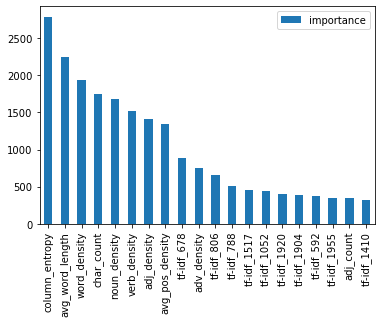

In [215]:
plt.figure(figsize=(20,7))
pd.DataFrame(lgb_classifier.feature_importances_, index=features,  columns=[
             'importance']).sort_values('importance', ascending=False)[:20].plot(kind='bar')

    ** We can see most of my POS density based features topping the feature importance chart. 

### Submission Ready 

In [216]:
test_features['pred_target']=lgb_classifier.predict(test_features[features])

In [217]:
test_features['predicted_category'] = test_features['pred_target'].apply(lambda x:get_key(x))

In [218]:
test_features[['hmid', 'predicted_category']].to_csv(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\Submission\\submission_8_2000_tfidf.csv",
    index=False)

## RF : 102

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
rf_classifier = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    random_state=9,
    max_depth=15,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    verbose=0,
    warm_start=True,
    class_weight={
        k: v
        for (k, v) in zip(
            np.unique(train_features.target),
            sklearn.utils.class_weight.compute_class_weight(
                'balanced', np.unique(train_features.target),
                train_features.target))
    })
rf_classifier.fit(train_features[features], train_features.target)

RandomForestClassifier(class_weight={1: 0.4099482300265846,
                                     2: 0.4214016036819963,
                                     3: 1.317667693553102,
                                     4: 1.3363893450100346,
                                     5: 2.1575110456553754,
                                     6: 7.454267904846712,
                                     7: 12.079571222428365},
                       criterion='entropy', max_depth=15, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=9,
                       warm_start=True)

In [89]:
rf_classifier.oob_score_

0.6902795317246322

In [90]:
train_features['pred_target_rf'] = rf_classifier.predict(train_features[features])

In [91]:
evaluate_model(np.array(train_features.target),np.array(train_features.pred_target_rf))

,Recall,Precision,F1_Score
overall,73.0144,73.0144,73.0144
1,68.97,95.75,80.18
2,76.33,71.7,73.94
3,85.53,90.27,87.84
4,62.56,46.86,53.58
5,66.88,51.71,58.33
6,86.46,49.02,62.56
7,89.47,45.59,60.4


In [92]:
print(metrics.classification_report(np.array(train_features.target),np.array(train_features.pred_target_rf)))

              precision    recall  f1-score   support

           1       0.96      0.69      0.80     20420
           2       0.72      0.76      0.74     19865
           3       0.90      0.86      0.88      6353
           4       0.47      0.63      0.54      6264
           5       0.52      0.67      0.58      3880
           6       0.49      0.86      0.63      1123
           7       0.46      0.89      0.60       693

    accuracy                           0.73     58598
   macro avg       0.64      0.77      0.68     58598
weighted avg       0.77      0.73      0.74     58598



### Submission Ready 

In [203]:
test_features['pred_target_rf']=rf_classifier.predict(test_features[features])

In [204]:
test_features['predicted_category'] = test_features['pred_target_rf'].apply(lambda x:get_key(x))

In [205]:
test_features[['hmid', 'predicted_category']].to_csv(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\submission_4.csv",
    index=False)

In [209]:
train_features[['pred_target_rf','pred_target']].apply(scipy.stats.mode,axis=1)

0        ([2], [1])
1        ([1], [2])
2        ([7], [2])
3        ([4], [2])
4        ([2], [2])
            ...    
60316    ([3], [2])
60317    ([3], [2])
60318    ([2], [1])
60319    ([6], [2])
60320    ([4], [2])
Length: 58581, dtype: object

## Word Embedding : 103

    ** Intuition behind word2vec based features is to capture semantic representation for specific word associated to different category. I am taking top words from each target class and then taking the mean and std of their extracted word2vec embedding such that we can capture the crisp information without blowing up the feature space to a huge dimension.

<AxesSubplot:>

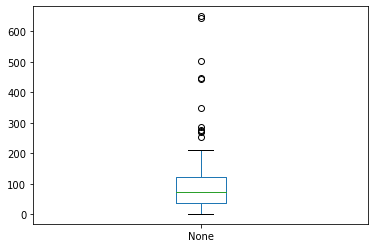

In [221]:
pd.Series(train_pre_processed.pre_processed_clean_hm.apply(
    lambda x: len(x.split())).value_counts().index.tolist()).plot(kind='box')

    ** We can see median line around ~70 words per comment  

In [308]:
top_words = []
for i in train_pre_processed.predicted_category.unique():
    cnt = Counter()
    for text in train_pre_processed[train_pre_processed.predicted_category ==
                                    i]['pre_processed_clean_hm'].values:
        for word in text.split():
            cnt[word] += 1
    print(i)
    print([x[0] for x in cnt.most_common(20)])
    top_words.extend([x[0] for x in cnt.most_common(20)])
del i, cnt, text, word

affection
['happy', 'go', 'make', 'get', 'time', 'family', 'day', 'son', 'daughter', 'see', 'husband', 'come', 'wife', 'take', 'home', 'last', 'dog', 'month', 'birthday', 'first']
exercise
['go', 'gym', 'run', 'workout', 'mile', 'work', 'exercise', 'good', 'get', 'morning', 'yoga', 'happy', 'able', 'great', 'felt', 'make', 'today', 'time', 'feel', 'really']
bonding
['friend', 'go', 'happy', 'get', 'time', 'make', 'see', 'old', 'meet', 'best', 'day', 'good', 'last', 'one', 'birthday', 'long', 'talk', 'year', 'great', 'really']
leisure
['go', 'watch', 'game', 'get', 'favorite', 'movie', 'play', 'show', 'new', 'video', 'time', 'happy', 'really', 'last', 'make', 'tv', 'see', 'read', 'one', 'good']
achievement
['get', 'work', 'happy', 'make', 'new', 'job', 'able', 'month', 'go', 'time', 'find', 'day', 'last', 'buy', 'finally', 'good', 'week', 'one', 'receive', 'today']
enjoy_the_moment
['happy', 'make', 'go', 'get', 'day', 'good', 'work', 'ate', 'really', 'feel', 'time', 'happiness', 'favor

In [94]:
from gensim.models import Word2Vec

    ** I have chosen Skip-Gram as 
            1. it captures better semantic relations for rare words
            2. it give different embedding for example "apple" : company and "apple" : fruit
                    
    ** I have also chosen hierarchical softmax as final layer of the Skip-Gram Model for faster results 
    ** Also, for training the word2Vec I will used both train and test such that proper word representation is obtained 

In [310]:
k = train_pre_processed.pre_processed_clean_hm.apply(lambda x: x.split()).tolist()
k.extend(test_pre_processed.pre_processed_clean_hm.apply(lambda x: x.split()).tolist())

In [311]:
len(k)

100534

In [312]:
w2v_model = Word2Vec(
    pd.Series(k),
    min_count=1,
    vector_size=100,
    window=5,
    sg=1,
    hs=1)

In [241]:
len(list(w2v_model.wv.key_to_index))

19446

In [313]:
w2v_model.wv['happy']

array([-3.10304582e-01,  3.15120041e-01, -1.33742103e-02,  1.00173838e-01,
        1.91882819e-01, -4.04044092e-01,  3.14833403e-01,  4.13333476e-01,
       -1.60684869e-01, -2.47694865e-01,  2.74390996e-01, -4.25434232e-01,
       -6.11535423e-02,  2.76607245e-01, -1.20700281e-02, -2.86193967e-01,
        3.72694939e-01, -2.57907331e-01, -3.17072213e-01, -1.89244688e-01,
        1.32234827e-01,  2.33149722e-01,  4.20171916e-02, -9.35758278e-02,
       -3.42510760e-01,  1.29480913e-01, -2.17548490e-01, -1.73632890e-01,
       -3.34629983e-01, -1.95536792e-01,  4.93870601e-02,  5.64051233e-02,
       -7.73824006e-02,  3.50607559e-02, -4.97307666e-02,  3.37634742e-01,
       -2.23565493e-02,  3.51429991e-02, -3.66731025e-02, -5.04075408e-01,
       -4.33606058e-02,  2.19426602e-02, -9.59364995e-02, -1.02905452e-01,
        5.01564264e-01,  1.10423706e-01, -4.45031792e-01, -2.39658535e-01,
        3.20601612e-01, -6.70616403e-02,  3.12476861e-03,  2.65699625e-01,
       -7.06752837e-02, -

In [259]:
w2v_model.wv['unknown']

array([ 0.1248979 ,  0.16202897,  0.18413958, -0.41765833,  0.48199254,
       -0.16362946, -0.01366806,  0.332025  , -0.20741314, -0.11597461,
       -0.08199276, -0.38374937, -0.20403214, -0.04032928,  0.22966608,
       -0.0051747 , -0.00923435, -0.14834978,  0.00128769, -0.34342065,
        0.01381208,  0.38579816,  0.4381407 , -0.07721095,  0.15708382,
        0.05578838, -0.14456087, -0.33238512, -0.01574454,  0.0900408 ,
       -0.15078513, -0.03702036,  0.03517194, -0.13025564, -0.11391814,
        0.20973922, -0.09115887, -0.24490428,  0.02616787, -0.41390777,
       -0.06503899, -0.21168838,  0.01692378,  0.05834926,  0.2653953 ,
        0.47822997, -0.04322888, -0.02029599, -0.07826191,  0.09756218,
        0.02001496, -0.12178562, -0.2550329 ,  0.00961916, -0.4944403 ,
       -0.14511143, -0.09086914, -0.1521083 , -0.05263077,  0.05499784,
        0.24118951, -0.05221226, -0.17348227,  0.21610314, -0.22960398,
        0.11506433,  0.14302726, -0.20483474, -0.14042953,  0.48

In [314]:
top_words = list(set(top_words))

In [315]:
len(top_words)

77

# Model Finalization 

    ** I have used various features capturing different aspect of sentences and words. Based on the experiments preformed I would conclude on LGBM as the final modeling choice for the exercise.

## Final Training 

In [342]:
lgb_classifier = LGBMClassifier(
    objective="multiclassova",
    metric="multi_logloss",
    num_class=7,
    num_leaves=15,
    max_depth=7,
    learning_rate=0.1,
    bagging_fraction=0.8,
    feature_fraction=0.8,
    bagging_freq=5,
    bagging_seed=2020,
    verbosity=-1,
    n_jobs=-1,
    random_state=9,
    reg_alpha=0.6,
    reg_lambda=0.6,
    class_weight={
        k: v
        for (k, v) in zip(
            np.unique(train_features.target),
            sklearn.utils.class_weight.compute_class_weight(
                'balanced', np.unique(train_features.target),
                train_features.target))
    },
    num_boost_round=600)
lgb_classifier.fit(train_features[features], train_features.target)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, bagging_seed=2020,
               class_weight={1: 0.40997012878899175, 2: 0.4213811153613851,
                             3: 1.317387883556255, 4: 1.3365261813537677,
                             5: 2.1577319587628865, 6: 7.455031166518254,
                             7: 12.080808080808081},
               feature_fraction=0.8, max_depth=7, metric='multi_logloss',
               num_boost_round=600, num_class=7, num_leaves=15,
               objective='multiclassova', random_state=9, reg_alpha=0.6,
               reg_lambda=0.6, verbosity=-1)

## Model Evaluate 

In [343]:
train_features['pred_target'] = lgb_classifier.predict(train_features[features])

In [344]:
evaluate_model(np.array(train_features.target),np.array(train_features.pred_target))

,Recall,Precision,F1_Score
overall,90.2959,90.2959,90.2959
1,92.86,97.01,94.89
2,84.51,94.93,89.42
3,98.76,94.67,96.67
4,86.43,72.22,78.69
5,94.28,73.59,82.66
6,100,78.86,88.18
7,100,81.72,89.94


In [345]:
print(metrics.classification_report(np.array(train_features.target),np.array(train_features.pred_target)))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95     20421
           2       0.95      0.85      0.89     19868
           3       0.95      0.99      0.97      6355
           4       0.72      0.86      0.79      6264
           5       0.74      0.94      0.83      3880
           6       0.79      1.00      0.88      1123
           7       0.82      1.00      0.90       693

    accuracy                           0.90     58604
   macro avg       0.85      0.94      0.89     58604
weighted avg       0.91      0.90      0.90     58604



## Feature Importance 

<AxesSubplot:>

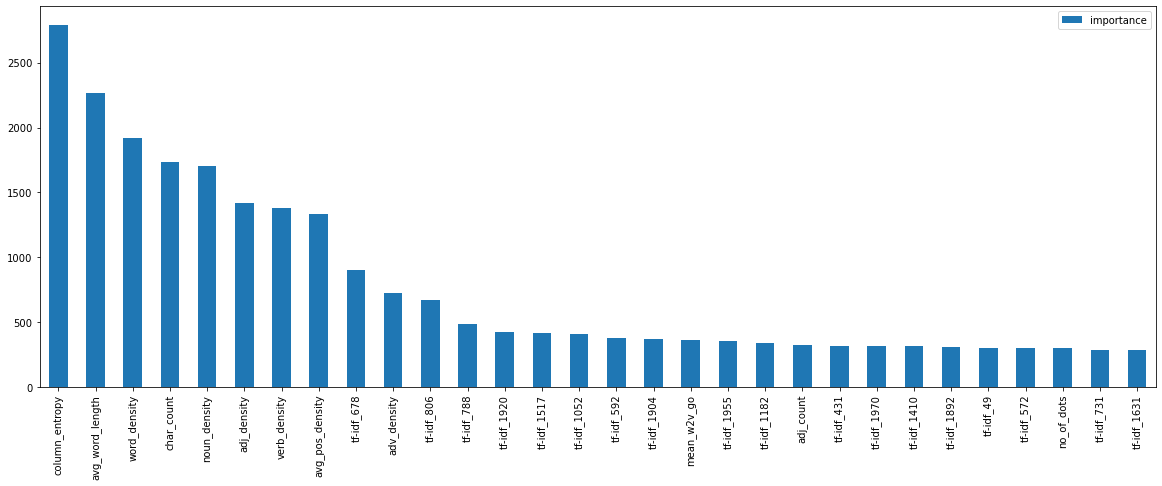

In [346]:
pd.DataFrame(lgb_classifier.feature_importances_, index=features,  columns=[
             'importance']).sort_values('importance', ascending=False)[:30].plot(kind='bar',figsize=(20,7))

    ** We can observe in top-30 Features:
            a. Entropy Based Feature is of highest importance.
            b. Density of POS based features are in the top-10.
            c. Only one Word2Vec based Feature is in top-30 Features.

## Final Submission 

In [305]:
test_features['pred_target']=lgb_classifier.predict(test_features[features])

In [306]:
test_features['predicted_category'] = test_features['pred_target'].apply(lambda x:get_key(x))

In [307]:
test_features[['hmid', 'predicted_category']].to_csv(
    "C:\\Users\\Zeus\\Downloads\\HackerEarth\\dataset\\Submission\\submission_9_w2v.csv",
    index=False)